# MLHC: Evaluation Notebook

Evaluate previously trained models (produced via the training notebook) on a set of subjects and optionally compute metrics given ground-truth labels. Reuses project .py modules (no duplicated logic).

In [14]:
# Path setup for 'project' package imports (robust to different run CWDs)
import sys, os, pathlib, datetime as _dt
cands = [
    pathlib.Path.cwd(),
    pathlib.Path.cwd().parent,
    pathlib.Path.cwd() / 'project',
    pathlib.Path.cwd().parent / 'project'
]
for p in cands:
    if p.is_dir():
        sp = str(p)
        if sp not in sys.path:
            sys.path.insert(0, sp)
print('sys.path[0]=', sys.path[0])

sys.path[0]= c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project


In [ ]:
# Configuration (auto-select latest run; strictly use labels.csv if present in run root)
import os, datetime as _dt, pathlib

GCP_PROJECT_ID = 'ml-for-healthcare-2025'
BASE_DIR = pathlib.Path.cwd()
# SUBJECTS_CSV may be replaced automatically if it has zero overlap with labels when AUTO_SAMPLE_SUBJECTS is True
SUBJECTS_CSV = str(BASE_DIR / 'data' / 'test_example_deprecated.csv')  # legacy smoke file (will be auto-replaced)

# Labels handling: training now copies its input labels to run_root/labels.csv
USE_RUN_LABELS = True  # if False, set LABELS_CSV manually below
LABELS_CSV = None  # manual override when USE_RUN_LABELS is False

# Auto-sample configuration
AUTO_SAMPLE_SUBJECTS = True
AUTO_SAMPLE_N = 1000  # sample size if zero overlap (capped by available labels)
AUTO_SAMPLE_RANDOM_STATE = 42

_core_files = [
    'preprocessor.joblib',
    'feature_columns.json',
    'model_mortality.joblib',
    'model_prolonged_los.joblib',
    'model_readmission.joblib'
]

MODELS_DIR = None
cwd = pathlib.Path.cwd()
run_search_roots = []
for root in [cwd, cwd.parent]:
    p = root / 'runs'
    if p.is_dir():
        run_search_roots.append(p)

for runs_root in run_search_roots:
    for run_dir in sorted([d for d in runs_root.iterdir() if d.is_dir()], reverse=True):
        mdir = run_dir / 'models'
        if mdir.is_dir() and all((mdir / f).exists() for f in _core_files):
            MODELS_DIR = str(mdir.resolve())
            run_root = mdir.parent
            if USE_RUN_LABELS:
                candidate = run_root / 'labels.csv'
                if candidate.is_file():
                    LABELS_CSV = str(candidate.resolve())
            break
    if MODELS_DIR:
        break

if MODELS_DIR is None:
    raise FileNotFoundError("No run models directory with required core artifacts found under 'runs/'. Train a model first.")

os.environ['MLHC_MODELS_DIR'] = MODELS_DIR

if not os.path.exists(SUBJECTS_CSV):
    print('Warning: initial SUBJECTS_CSV not found (will sample if enabled):', SUBJECTS_CSV)
if not USE_RUN_LABELS and LABELS_CSV and not os.path.exists(LABELS_CSV):
    raise FileNotFoundError(f'LABELS_CSV specified but not found: {LABELS_CSV}')

EVAL_RUN_ID = _dt.datetime.now().strftime('%Y%m%d_%H%M%S')
EVAL_OUT_DIR = os.path.abspath(os.path.join(MODELS_DIR, '..', 'evaluation', EVAL_RUN_ID))
os.makedirs(EVAL_OUT_DIR, exist_ok=True)

print('GCP_PROJECT_ID:', GCP_PROJECT_ID)
print('MODELS_DIR:', MODELS_DIR)
print('SUBJECTS_CSV (initial):', SUBJECTS_CSV)
print('AUTO_SAMPLE_SUBJECTS:', AUTO_SAMPLE_SUBJECTS, 'AUTO_SAMPLE_N:', AUTO_SAMPLE_N)
print('USE_RUN_LABELS:', USE_RUN_LABELS)
print('LABELS_CSV:', LABELS_CSV)
print('EVAL_OUT_DIR:', EVAL_OUT_DIR)

GCP_PROJECT_ID, SUBJECTS_CSV, USE_RUN_LABELS, LABELS_CSV, MODELS_DIR, EVAL_OUT_DIR

GCP_PROJECT_ID: ml-for-healthcare-2025
MODELS_DIR: C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\runs\20250905_143527\models
SUBJECTS_CSV: c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\data\test_example.csv
USE_RUN_LABELS: True
LABELS_CSV: C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\runs\20250905_143527\labels.csv
EVAL_OUT_DIR: C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\runs\20250905_143527\evaluation\20250912_101129


('ml-for-healthcare-2025',
 'c:\\Users\\Almog Luz\\Documents\\GitHub\\mlhc-final-project\\project\\data\\test_example.csv',
 True,
 'C:\\Users\\Almog Luz\\Documents\\GitHub\\mlhc-final-project\\project\\runs\\20250905_143527\\labels.csv',
 'C:\\Users\\Almog Luz\\Documents\\GitHub\\mlhc-final-project\\project\\runs\\20250905_143527\\models',
 'C:\\Users\\Almog Luz\\Documents\\GitHub\\mlhc-final-project\\project\\runs\\20250905_143527\\evaluation\\20250912_101129')

In [16]:
# Sanity check model artifacts (strict, no discovery)
import os
needed = [
    'preprocessor.joblib',
    'feature_columns.json',
    'model_mortality.joblib',
    'model_prolonged_los.joblib',
    'model_readmission.joblib'
]
print('Models dir:', MODELS_DIR)
missing = [f for f in needed if not os.path.exists(os.path.join(MODELS_DIR, f))]
if missing:
    raise FileNotFoundError(f"Missing required artifacts (no fallback): {missing}")
print('All core model artifacts present.')
[f for f in os.listdir(MODELS_DIR) if f.endswith('.joblib') or f.endswith('.json')]

Models dir: C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\runs\20250905_143527\models
All core model artifacts present.


['feature_columns.json',
 'metrics.json',
 'model_mortality.joblib',
 'model_prolonged_los.joblib',
 'model_readmission.joblib',
 'mortality_curves.json',
 'preprocessor.joblib',
 'prolonged_los_curves.json',
 'readmission_curves.json',
 'run_metadata.json']

In [17]:
# Load subject IDs and run inference using pipeline module
import pandas as pd, os
from google.cloud import bigquery
from project.unseen_data_evaluation import run_pipeline_on_unseen_data
if not os.path.exists(SUBJECTS_CSV):
    raise FileNotFoundError(f'SUBJECTS_CSV not found: {SUBJECTS_CSV}')
subjects_df = pd.read_csv(SUBJECTS_CSV)
if 'subject_id' not in subjects_df.columns:
    raise ValueError('SUBJECTS_CSV must contain subject_id column')
subject_ids = subjects_df['subject_id'].dropna().astype(int).tolist()
print('n subjects:', len(subject_ids))
bq_client = bigquery.Client(project=GCP_PROJECT_ID)
preds = run_pipeline_on_unseen_data(subject_ids, bq_client)
preds.head()

n subjects: 50


,subject_id,mortality_proba,prolonged_LOS_proba,readmission_proba
0,1046,0.126984,0.641560,0.047480
1,1597,0.336689,0.538983,0.084629
2,1728,0.012375,0.343136,0.029925
3,1844,0.122131,0.679046,0.070189
4,3329,0.010063,0.851561,0.036328


In [18]:
# Save predictions to evaluation output dir
preds_path = os.path.join(EVAL_OUT_DIR, 'predictions.csv')
preds.to_csv(preds_path, index=False)
print('Saved predictions ->', preds_path)

Saved predictions -> C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\runs\20250905_143527\evaluation\20250912_101129\predictions.csv


In [ ]:
# Auto-sample subject IDs from labels if zero (or very low) overlap
import pandas as pd, os, pathlib, json, numpy as np

if LABELS_CSV and AUTO_SAMPLE_SUBJECTS:
    labels_df__as = pd.read_csv(LABELS_CSV, usecols=['subject_id'])
    labels_ids_set = set(labels_df__as['subject_id'].astype(int))

    # Load current subjects (file may be legacy or missing)
    if os.path.exists(SUBJECTS_CSV):
        subj_df__as = pd.read_csv(SUBJECTS_CSV)
        if 'subject_id' not in subj_df__as.columns:
            raise ValueError('Current SUBJECTS_CSV lacks subject_id column')
        current_ids = subj_df__as['subject_id'].dropna().astype(int).tolist()
    else:
        current_ids = []

    overlap = len([sid for sid in current_ids if sid in labels_ids_set])
    print(f'Current subjects: {len(current_ids)} | Labels subjects: {len(labels_ids_set)} | Overlap: {overlap}')

    MIN_REQUIRED = 1  # if zero, resample; could be increased later
    if overlap < MIN_REQUIRED:
        sample_n = min(AUTO_SAMPLE_N, len(labels_ids_set))
        rng = np.random.RandomState(AUTO_SAMPLE_RANDOM_STATE)
        sampled_ids = rng.choice(list(labels_ids_set), size=sample_n, replace=False)
        sampled_df = pd.DataFrame({'subject_id': sampled_ids})
        sampled_path = pathlib.Path(EVAL_OUT_DIR) / 'sampled_subjects.csv'
        sampled_df.to_csv(sampled_path, index=False)
        SUBJECTS_CSV = str(sampled_path.resolve())
        print(f'No / insufficient overlap -> sampled {sample_n} subject_ids from labels to {SUBJECTS_CSV}')
        # Re-run inference pipeline automatically for the sampled set
        from google.cloud import bigquery
        from project.unseen_data_evaluation import run_pipeline_on_unseen_data
        bq_client_resample = bigquery.Client(project=GCP_PROJECT_ID)
        new_subject_ids = sampled_df['subject_id'].astype(int).tolist()
        preds = run_pipeline_on_unseen_data(new_subject_ids, bq_client_resample)
        preds_path = os.path.join(EVAL_OUT_DIR, 'predictions_resampled.csv')
        preds.to_csv(preds_path, index=False)
        print('Resampled predictions saved ->', preds_path)
    else:
        print('Sufficient overlap detected; keeping existing SUBJECTS_CSV.')
else:
    print('Auto-sample disabled or LABELS_CSV missing; skipping auto-sample logic.')

SUBJECTS_CSV

In [19]:
# Optional metrics using labels.csv in run root (if present) or manual override
from project.metrics_utils import compute_binary_metrics, metrics_to_dict
import json, os, pandas as pd

metrics = {}
diag = {}
if LABELS_CSV:
    if not os.path.exists(LABELS_CSV):
        raise FileNotFoundError(f'LABELS_CSV not found: {LABELS_CSV}')
    labels_df = pd.read_csv(LABELS_CSV)
    if 'subject_id' not in labels_df.columns:
        raise ValueError('Labels CSV must contain subject_id')
    orig_label_cols = list(labels_df.columns)
    rename_map = {
        'prolonged_los': 'prolonged_los_label',
        'prolonged_los_label': 'prolonged_los_label',
        'prolonged_los>7d': 'prolonged_los_label',
        'mortality': 'mortality_label',
        'readmission': 'readmission_label',
    }
    norm = {c: c for c in labels_df.columns}
    for c in list(labels_df.columns):
        lc = c.lower()
        if lc in rename_map:
            norm[c] = rename_map[lc]
        elif lc.endswith('_label'):
            norm[c] = lc
    labels_df = labels_df.rename(columns=norm)
    renamed_label_cols = [c for c in labels_df.columns if c.endswith('_label')]

    merged = preds.merge(labels_df, on='subject_id', how='inner')
    diag['pred_rows'] = len(preds)
    diag['label_rows'] = len(labels_df)
    diag['merged_rows'] = len(merged)
    diag['label_cols_before'] = orig_label_cols
    diag['label_cols_after'] = renamed_label_cols

    mapping = [
        ('mortality_label','mortality_proba','mortality'),
        ('prolonged_los_label','prolonged_LOS_proba','prolonged_los'),
        ('readmission_label','readmission_proba','readmission'),
    ]
    tasks_attempted = []
    for y_col, p_col, name in mapping:
        if y_col in merged.columns and p_col in merged.columns:
            y_series = merged[y_col].dropna().astype(int)
            p_series = merged.loc[y_series.index, p_col].astype(float)
            if y_series.size:
                try:
                    m = compute_binary_metrics(y_series.values, p_series.values, threshold_objective='f1')
                    metrics[name] = metrics_to_dict(m)
                    tasks_attempted.append(name)
                except Exception as e:
                    diag[f'error_{name}'] = str(e)
            else:
                diag[f'empty_labels_{name}'] = True
        else:
            missing_parts = []
            if y_col not in merged.columns:
                missing_parts.append('label')
            if p_col not in merged.columns:
                missing_parts.append('proba')
            diag[f'missing_{name}'] = ','.join(missing_parts)
    diag['tasks_attempted'] = tasks_attempted

    metrics_path = os.path.join(EVAL_OUT_DIR, 'metrics.json')
    with open(metrics_path,'w',encoding='utf-8') as f:
        json.dump(metrics, f, indent=2)
    print('Saved metrics ->', metrics_path)

    # Always write diagnostics
    diag_path = os.path.join(EVAL_OUT_DIR, 'metrics_diagnostics.json')
    with open(diag_path,'w',encoding='utf-8') as f:
        json.dump(diag, f, indent=2)
    print('Saved diagnostics ->', diag_path)

    if not metrics:
        print('\nWARNING: metrics dict is empty. See metrics_diagnostics.json for details.')
        print('Summary diagnostics:', diag)
else:
    print('No labels.csv found for this run (USE_RUN_LABELS=' + str(USE_RUN_LABELS) + '): skipping metrics.')
metrics if metrics else None

Saved metrics -> C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\runs\20250905_143527\evaluation\20250912_101129\metrics.json
Saved diagnostics -> C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\runs\20250905_143527\evaluation\20250912_101129\metrics_diagnostics.json

Summary diagnostics: {'pred_rows': 50, 'label_rows': 28473, 'merged_rows': 0, 'label_cols_before': ['subject_id', 'hadm_id', 'mortality_label', 'prolonged_los_label', 'readmission_label'], 'label_cols_after': ['mortality_label', 'prolonged_los_label', 'readmission_label'], 'empty_labels_mortality': True, 'empty_labels_prolonged_los': True, 'empty_labels_readmission': True, 'tasks_attempted': []}


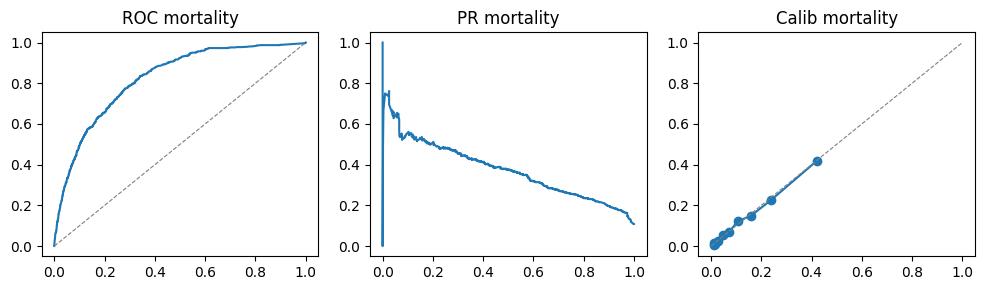

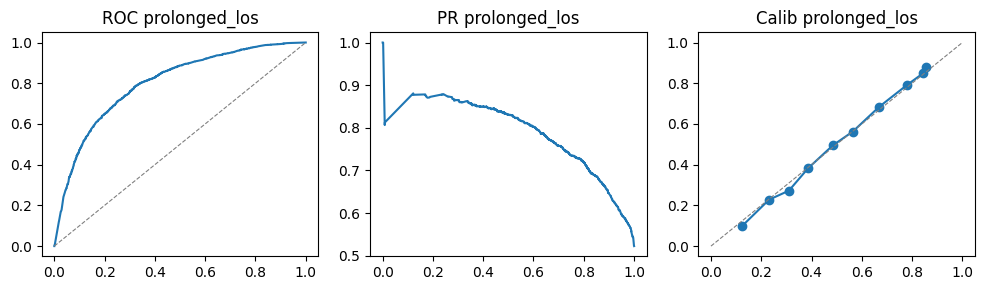

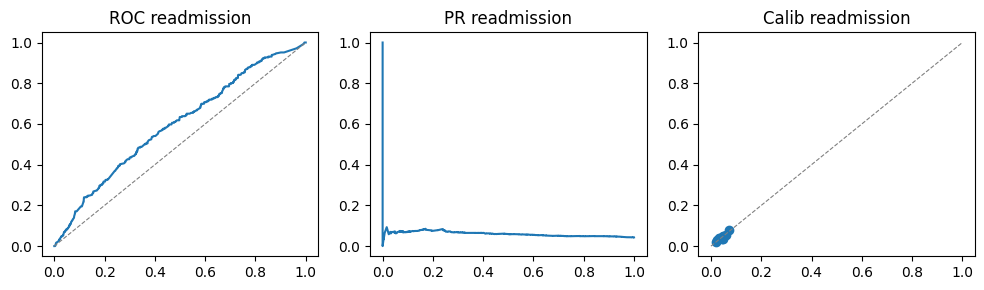

In [20]:
# (Optional) Display calibration & curves if artifacts present in models dir
import json, pandas as pd, os, matplotlib.pyplot as plt
targets = ['mortality','prolonged_los','readmission']
curve_files = {t: os.path.join(MODELS_DIR, f'{t}_curves.json') for t in targets}
plots_shown = False
for t, fp in curve_files.items():
    if os.path.exists(fp):
        with open(fp,'r',encoding='utf-8') as f:
            data = json.load(f)
        try:
            plt.figure(figsize=(10,3))
            plt.subplot(1,3,1)
            plt.plot(data.get('roc_fpr',[]), data.get('roc_tpr',[]))
            plt.plot([0,1],[0,1],'--',color='gray',linewidth=0.8)
            plt.title(f'ROC {t}')
            plt.subplot(1,3,2)
            plt.plot(data.get('pr_recall',[]), data.get('pr_precision',[]))
            plt.title(f'PR {t}')
            plt.subplot(1,3,3)
            calib_p = data.get('calibration_mean_proba',[])
            calib_r = data.get('calibration_empirical_rate',[])
            if calib_p and calib_r:
                plt.plot(calib_p, calib_r, marker='o')
                plt.plot([0,1],[0,1],'--',color='gray',linewidth=0.8)
            plt.title(f'Calib {t}')
            plt.tight_layout()
            plots_shown = True
        except Exception as e:
            print('Plot error for', t, e)
if not plots_shown:
    print('No curve artifacts found or plotting failed.')

### Notes
- Set `LABELS_CSV` if you want metrics; otherwise only predictions are produced.
- Models directory is auto-resolved via `MLHC_MODELS_DIR` env var if set (training notebook sets it).
- Evaluation outputs stored under the evaluation run directory next to models.

### Extended Visual Diagnostics
Additional plots: consolidated metrics table, confusion matrices, ROC/PR overlay, prevalence & calibration detail. Run only after metrics cell above.

In [21]:
# Metrics summary & confusion matrices (requires metrics variable from earlier cell)
import pandas as pd, numpy as np, os, json, matplotlib.pyplot as plt
from itertools import product

if 'metrics' not in globals() or not metrics:
    print('No metrics available (ensure labels were found). Skipping extended diagnostics.')
else:
    rows = []
    for name, m in metrics.items():
        rows.append({
            'task': name,
            'n': m.get('n'),
            'positives': m.get('positives'),
            'prev': m.get('prevalence'),
            'roc_auc': m.get('roc_auc'),
            'pr_auc': m.get('pr_auc'),
            'brier': m.get('brier'),
            'ece': m.get('ece'),
            'threshold': m.get('threshold'),
            'precision': m.get('precision'),
            'recall': m.get('recall'),
            'f1': m.get('f1'),
            'specificity': m.get('specificity'),
            'accuracy': m.get('accuracy'),
        })
    summary_df = pd.DataFrame(rows).set_index('task')
    display(summary_df.round(4))

    # Confusion matrices if cm present
    cm_tasks = [t for t,mv in metrics.items() if mv.get('cm')]
    if cm_tasks:
        fig, axes = plt.subplots(1, len(cm_tasks), figsize=(5*len(cm_tasks),4))
        if len(cm_tasks)==1:
            axes = [axes]
        for ax, task in zip(axes, cm_tasks):
            cm = metrics[task]['cm']
            tp, tn, fp, fn = cm.get('tp'), cm.get('tn'), cm.get('fp'), cm.get('fn')
            # Reconstruct matrix [[tn, fp],[fn,tp]]
            mat = np.array([[tn, fp],[fn, tp]], dtype=float)
            ax.imshow(mat, cmap='Blues')
            for i,j in product(range(2), range(2)):
                ax.text(j, i, int(mat[i,j]), ha='center', va='center', color='black')
            ax.set_xticks([0,1]); ax.set_yticks([0,1])
            ax.set_xticklabels(['Neg','Pos']); ax.set_yticklabels(['Neg','Pos'])
            ax.set_xlabel('Pred'); ax.set_ylabel('True')
            ax.set_title(f'CM: {task}')
        plt.tight_layout()
    else:
        print('No confusion matrices present in metrics (maybe thresholding disabled).')

No metrics available (ensure labels were found). Skipping extended diagnostics.


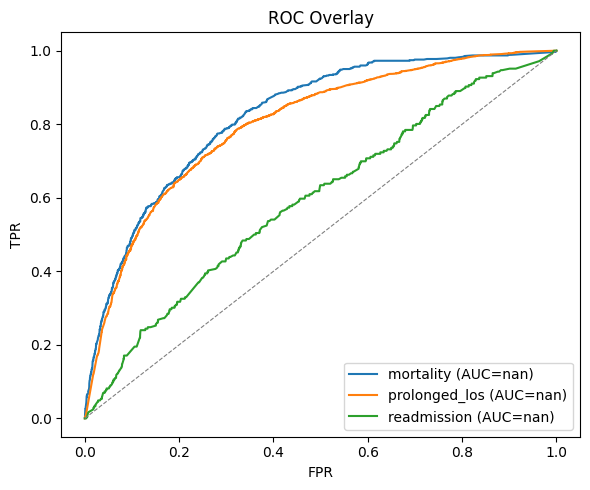

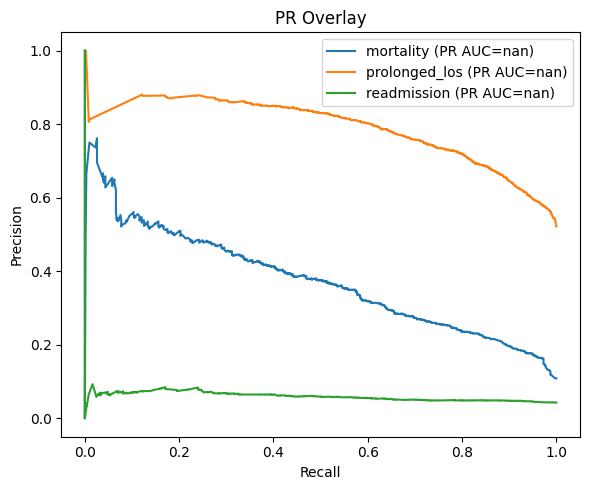

In [22]:
# Combined ROC & PR overlays (reusing curve JSON artifacts)
import json, os, matplotlib.pyplot as plt, numpy as np
curve_tasks = ['mortality','prolonged_los','readmission']
curves = {}
for t in curve_tasks:
    fp = os.path.join(MODELS_DIR, f'{t}_curves.json')
    if os.path.exists(fp):
        try:
            with open(fp,'r',encoding='utf-8') as f: curves[t] = json.load(f)
        except Exception as e:
            print('Failed to load curve file', fp, e)

if curves:
    plt.figure(figsize=(6,5))
    for name,data in curves.items():
        fpr = data.get('roc_fpr',[]); tpr = data.get('roc_tpr',[])
        if fpr and tpr:
            plt.plot(fpr, tpr, label=f'{name} (AUC={data.get("roc_auc",float("nan")):.3f})')
    plt.plot([0,1],[0,1],'--',color='gray',linewidth=0.8)
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Overlay'); plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,5))
    for name,data in curves.items():
        r = data.get('pr_recall',[]); p = data.get('pr_precision',[])
        if r and p:
            plt.plot(r, p, label=f'{name} (PR AUC={data.get("pr_auc",float("nan")):.3f})')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Overlay'); plt.legend(); plt.tight_layout()
    plt.show()
else:
    print('No curve artifacts available for overlays.')

In [23]:
# Detailed calibration: bar (count) + reliability curve per task
import matplotlib.pyplot as plt
if 'metrics' in globals() and metrics:
    for task, m in metrics.items():
        cb = m.get('calibration_bins')
        if not cb:
            continue
        try:
            mean_p = cb.get('mean_proba', [])
            emp = cb.get('empirical_rate', [])
            counts = cb.get('count', [])
            if not mean_p or not emp:
                continue
            fig, ax1 = plt.subplots(figsize=(6,4))
            ax1.bar(mean_p, counts, width=0.04, color='lightgray', alpha=0.7, label='Bin count')
            ax1.set_xlabel('Mean predicted probability')
            ax1.set_ylabel('Count', color='gray')
            ax2 = ax1.twinx()
            ax2.plot(mean_p, emp, marker='o', label='Empirical rate', color='C1')
            ax2.plot([0,1],[0,1],'--',color='gray',linewidth=0.8)
            ax2.set_ylabel('Empirical rate', color='C1')
            ax1.set_title(f'Calibration Detail: {task}')
            fig.tight_layout()
            plt.show()
        except Exception as e:
            print('Calibration plot failed for', task, e)
else:
    print('Metrics not available; skip calibration detail.')

Metrics not available; skip calibration detail.


In [24]:
# Prevalence bar chart + export summary
import pandas as pd, matplotlib.pyplot as plt, os
if 'metrics' in globals() and metrics:
    prev_rows = []
    for name, m in metrics.items():
        prev_rows.append({'task': name, 'prevalence': m.get('prevalence'), 'n': m.get('n')})
    prev_df = pd.DataFrame(prev_rows)
    if not prev_df.empty:
        plt.figure(figsize=(4,3))
        plt.bar(prev_df['task'], prev_df['prevalence'])
        plt.ylabel('Prevalence')
        plt.title('Label Prevalence by Task')
        for i,(task,row) in enumerate(prev_df.set_index('task').iterrows()):
            plt.text(i, row['prevalence']+0.005, f"n={int(row['n'])}", ha='center', fontsize=8)
        plt.ylim(0, max(0.05, prev_df['prevalence'].max()*1.15))
        plt.tight_layout()
        plt.show()
    # Export combined summary if available
    if 'summary_df' in globals():
        out_csv = os.path.join(EVAL_OUT_DIR, 'extended_metrics_summary.csv')
        summary_df.to_csv(out_csv)
        print('Exported extended metrics summary ->', out_csv)
else:
    print('Metrics not available; skipping prevalence and export.')

Metrics not available; skipping prevalence and export.


### Run Comparison (Latest Two Training Runs)
Automatically loads metrics.json from the two most recent run directories under runs/ and produces a delta table plus selected plots. Adjust MAX_RUNS or filter logic as needed.

Latest run:   20250905_143527 -> 2025-09-05 14:35:27
Baseline run: 20250905_141147 -> 2025-09-05 14:11:47


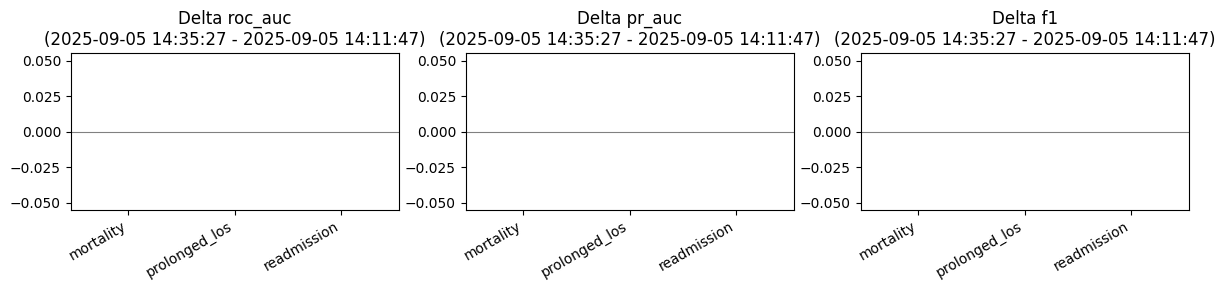


Per-task metric comparison tables:


,2025-09-05 14:11:47,2025-09-05 14:35:27,delta
metric,,,
roc_auc,0.8230,0.8230,0.0000
pr_auc,0.3750,0.3750,0.0000
brier,0.0811,0.0811,0.0000
ece,0.0072,0.0072,0.0000
f1,0.4346,0.4346,0.0000
precision,0.3497,0.3497,0.0000
recall,0.5740,0.5740,0.0000
specificity,0.8691,0.8691,0.0000
accuracy,0.8369,0.8369,0.0000


,2025-09-05 14:11:47,2025-09-05 14:35:27,delta
metric,,,
roc_auc,0.8001,0.8001,0.0000
pr_auc,0.7942,0.7942,0.0000
brier,0.1818,0.1818,0.0000
ece,0.0132,0.0132,0.0000
f1,0.7602,0.7602,0.0000
precision,0.6844,0.6844,0.0000
recall,0.8548,0.8548,0.0000
specificity,0.5686,0.5686,0.0000
accuracy,0.7182,0.7182,0.0000


,2025-09-05 14:11:47,2025-09-05 14:35:27,delta
metric,,,
roc_auc,0.5954,0.5954,0.0000
pr_auc,0.0601,0.0601,0.0000
brier,0.0412,0.0412,0.0000
ece,0.0055,0.0055,0.0000
f1,0.1242,0.1242,0.0000
precision,0.0838,0.0838,0.0000
recall,0.2398,0.2398,0.0000
specificity,0.8816,0.8816,0.0000
accuracy,0.8539,0.8539,0.0000


Exported per-task tables to models dir of latest run.
Saved overall comparison CSV -> c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\runs\20250905_143527\models\comparison_20250905_143527_vs_20250905_141147.csv


In [25]:
# Compare baseline run vs latest run (baseline = manual ID or heuristic pre-change)
import os, json, pathlib, pandas as pd, matplotlib.pyplot as plt, datetime as _dt

# --- Configuration ---
# Optionally pin a specific baseline run ID (directory name like '20250905_123932').
BASELINE_RUN_ID = None  # e.g. '20250905_123932' or leave None to auto-detect
# Heuristic: choose the most recent earlier run with mortality ECE <= threshold (indicating calibrated model)
AUTO_BASELINE_MORTALITY_ECE_MAX = 0.05

RUNS_BASES = []
for base in [pathlib.Path.cwd(), pathlib.Path.cwd().parent]:
    cand = base / 'runs'
    if cand.is_dir():
        RUNS_BASES.append(cand)

run_dirs = []
for rb in RUNS_BASES:
    for d in rb.iterdir():
        if d.is_dir() and (d / 'models' / 'metrics.json').is_file():
            run_dirs.append(d)

if len(run_dirs) < 2:
    print('Fewer than 2 runs with metrics.json found; skipping comparison.')
else:
    # Sort all runs descending (newest first)
    run_dirs = sorted(run_dirs, key=lambda p: p.name, reverse=True)
    latest = run_dirs[0]

    # Resolve baseline
    baseline = None
    if BASELINE_RUN_ID:
        for rd in run_dirs[1:]:  # exclude newest
            if rd.name == BASELINE_RUN_ID:
                baseline = rd
                break
        if baseline is None:
            print(f"Requested BASELINE_RUN_ID={BASELINE_RUN_ID} not found; falling back to heuristic.")

    if baseline is None and not BASELINE_RUN_ID:
        # Heuristic search: mortality ECE <= threshold
        for rd in run_dirs[1:]:
            try:
                with open(rd / 'models' / 'metrics.json','r',encoding='utf-8') as f:
                    metrics_tmp = json.load(f)
                mort = metrics_tmp.get('mortality', {})
                ece = mort.get('ece')
                if ece is not None and ece <= AUTO_BASELINE_MORTALITY_ECE_MAX:
                    baseline = rd
                    break
            except Exception:
                continue

    if baseline is None:
        # Fallback: second newest
        baseline = run_dirs[1]

    def _fmt(ts: str) -> str:
        try:
            dt = _dt.datetime.strptime(ts, '%Y%m%d_%H%M%S')
            return dt.strftime('%Y-%m-%d %H:%M:%S')
        except Exception:
            return ts

    newest = latest.name
    older = baseline.name
    newest_fmt, older_fmt = _fmt(newest), _fmt(older)
    print(f'Latest run:   {newest} -> {newest_fmt}')
    print(f'Baseline run: {older} -> {older_fmt}')
    if newest == older:
        print('Warning: baseline and latest are identical; no comparison performed.')

    target_runs = [latest, baseline]
    metrics_by_run = {}
    for rd in target_runs:
        with open(rd / 'models' / 'metrics.json','r',encoding='utf-8') as f:
            metrics_by_run[rd.name] = json.load(f)

    core_keys = ['roc_auc','pr_auc','brier','ece','f1','precision','recall','specificity','accuracy','prevalence']
    rows = []
    tasks = sorted({t for m in metrics_by_run.values() for t in m.keys()})
    for task in tasks:
        row = {'task': task}
        for rd in target_runs:
            m = metrics_by_run[rd.name].get(task, {})
            for k in core_keys:
                row[f'{rd.name}:{k}'] = m.get(k)
        rows.append(row)
    comp_df = pd.DataFrame(rows).set_index('task')
    for k in core_keys:
        nk = f'{newest}:{k}'; ok = f'{older}:{k}'
        if nk in comp_df.columns and ok in comp_df.columns:
            comp_df[f'delta_{k}'] = comp_df[nk] - comp_df[ok]

    # Bar plot for selected metrics deltas (no full table display)
    plot_metrics = ['roc_auc','pr_auc','f1']
    nplot = len(plot_metrics)
    fig, axes = plt.subplots(1, nplot, figsize=(4*nplot,3))
    if nplot == 1:
        axes = [axes]
    index_labels = list(comp_df.index)
    x_positions = list(range(len(index_labels)))
    for ax, mk in zip(axes, plot_metrics):
        col = f'delta_{mk}'
        if col in comp_df.columns:
            ax.bar(x_positions, comp_df[col])
            ax.axhline(0,color='gray',linewidth=0.8)
            ax.set_title(f'Delta {mk}\n({newest_fmt} - {older_fmt})')
            ax.set_xticks(x_positions)
            ax.set_xticklabels(index_labels, rotation=30, ha='right')
    plt.tight_layout(); plt.show()

    # Per-task pivot tables
    comparison_tables = {}
    newest_col_name = f'{newest_fmt}'
    older_col_name = f'{older_fmt}'
    print('\nPer-task metric comparison tables:')
    for task in index_labels:
        data_rows = []
        for metric in core_keys:
            new_col = f'{newest}:{metric}'
            old_col = f'{older}:{metric}'
            if new_col in comp_df.columns and old_col in comp_df.columns:
                new_v = comp_df.loc[task, new_col]
                old_v = comp_df.loc[task, old_col]
                delta_v = new_v - old_v if (pd.notnull(new_v) and pd.notnull(old_v)) else float('nan')
                data_rows.append({
                    'metric': metric,
                    older_col_name: old_v,
                    newest_col_name: new_v,
                    'delta': delta_v,
                })
        if not data_rows:
            continue
        tdf = pd.DataFrame(data_rows).set_index('metric').round(4)
        comparison_tables[task] = tdf
        display(tdf.style.format(precision=4).set_caption(f'{task} ({newest_fmt} vs {older_fmt})'))
        out_csv_task = latest / 'models' / f'{task}_comparison_table_{newest}_vs_{older}.csv'
        tdf.to_csv(out_csv_task)
    print('Exported per-task tables to models dir of latest run.')

    out_csv = latest / 'models' / f'comparison_{newest}_vs_{older}.csv'
    comp_df.to_csv(out_csv)
    print('Saved overall comparison CSV ->', out_csv)

    comparison_tables

### Leakage Audit
Check for potential label leakage, especially for prolonged LOS (near-perfect metrics may indicate inclusion of post-outcome information such as true LOS or discharge-dependent features). The following cell:
- Rebuilds features from cached extraction parquet files.
- Identifies suspicious columns (name patterns or extremely high univariate AUC / correlation).
- Reports top univariate predictors for prolonged_los.
- Tests impact of removing suspicious columns.
- Performs a negative control by shuffling labels for suspicious features.
Interpret cautiously; absence of flags isn't a proof of no leakage.

In [26]:
# Leakage audit code
import os, json, pathlib, numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Attempt to reconstruct feature matrix from preprocessor + feature_columns + original cohort labels
models_dir = pathlib.Path(MODELS_DIR)
run_root = models_dir.parent
labels_path = run_root / 'labels.csv'
feature_cols_fp = models_dir / 'feature_columns.json'
preprocessor_fp = models_dir / 'preprocessor.joblib'

if not labels_path.is_file() or not feature_cols_fp.is_file():
    print('Required artifacts (labels.csv / feature_columns.json) not found; cannot run leakage audit.')
else:
    with open(feature_cols_fp,'r',encoding='utf-8') as f:
        feature_columns = json.load(f)
    from project.features import build_features

    # Robust cache dir discovery (avoid __file__ which is undefined in notebooks)
    candidates = [
        run_root / 'data' / 'extracted_cache',                  # sibling to models dir
        pathlib.Path.cwd() / 'data' / 'extracted_cache',        # cwd/data
        pathlib.Path.cwd().parent / 'project' / 'data' / 'extracted_cache'  # parent/project/data
    ]
    cache_dir = None
    for cand in candidates:
        if cand.is_dir():
            cache_dir = cand
            break
    if cache_dir is None:
        cache_dir = candidates[0]
        print('Cache directory not found in typical locations; proceeding with:', cache_dir)

    def _maybe_read(name):
        fp = cache_dir / name
        return pd.read_parquet(fp) if fp.is_file() else pd.DataFrame()

    first_adm = _maybe_read('first_admissions.parquet')
    if first_adm.empty:
        print('No cached extractions found; skipping full rebuild (cannot conclusively check leakage).')
    else:
        if 'admittime' in first_adm and 'dischtime' in first_adm:
            first_adm['admittime'] = pd.to_datetime(first_adm['admittime'])
            first_adm['dischtime'] = pd.to_datetime(first_adm['dischtime'])
            first_adm['los_hours'] = (first_adm['dischtime'] - first_adm['admittime']).dt.total_seconds()/3600.0
        demo = _maybe_read('demographics.parquet')
        vitals = _maybe_read('vitals_48h.parquet')
        labs = _maybe_read('labs_48h.parquet')
        rx = _maybe_read('prescriptions_48h.parquet')
        proc = _maybe_read('procedures_48h.parquet')
        X_full = build_features(first_adm, demo, vitals, labs, rx, proc)
        labels_df = pd.read_csv(labels_path)
        rename_map = { 'prolonged_los':'prolonged_los_label', 'prolonged_LOS':'prolonged_los_label' }
        norm = {c:c for c in labels_df.columns}
        for c in list(labels_df.columns):
            lc = c.lower()
            if lc in rename_map:
                norm[c] = rename_map[lc]
            elif lc.endswith('_label'):
                norm[c] = lc
        labels_df = labels_df.rename(columns=norm)
        if 'prolonged_los_label' not in labels_df.columns:
            print('prolonged_los_label missing; skipping LOS leakage audit.')
        else:
            X_full = X_full.reindex(labels_df['subject_id']).fillna(0.0)
            y = labels_df['prolonged_los_label'].astype(int).values
            X = X_full[feature_columns].copy()
            suspect_name_patterns = ['los', 'length', 'discharge', 'death', 'expired']
            suspicious_columns = [c for c in X.columns if any(pat in c.lower() for pat in suspect_name_patterns)]
            auc_scores = []
            for col in feature_columns:
                vals = X[col].values
                if np.unique(vals).size <= 1:
                    continue
                try:
                    auc = roc_auc_score(y, vals)
                    if auc < 0.5:
                        auc = 1 - auc
                    auc_scores.append((col, auc))
                except Exception:
                    continue
            auc_scores.sort(key=lambda x: x[1], reverse=True)
            top_auc = auc_scores[:25]
            extreme_auc = [c for c,a in top_auc if a >= 0.995]
            print('Top 10 univariate AUC features (symmetrized):')
            for c,a in top_auc[:10]:
                mark = ' **HIGH**' if a >= 0.99 else ''
                if c in suspicious_columns:
                    mark += ' (name-flag)'
                print(f'  {c}: {a:.4f}{mark}')
            if extreme_auc:
                print('\nFeatures with extreme univariate AUC >= 0.995 (possible leakage):', extreme_auc)
            if suspicious_columns and not extreme_auc:
                print('\nName-flagged columns (pattern match) but without extreme AUC:', suspicious_columns[:10], '...')
            def fit_eval(cols):
                X_sub = X[cols]
                imp = SimpleImputer(strategy='median')
                scl = StandardScaler(with_mean=False)
                pipe = Pipeline([
                    ('imp', imp), ('sc', scl), ('clf', LogisticRegression(max_iter=500, class_weight='balanced', solver='liblinear'))
                ])
                X_tr, X_te, y_tr, y_te = train_test_split(X_sub, y, test_size=0.3, random_state=42, stratify=y)
                pipe.fit(X_tr, y_tr)
                proba = pipe.predict_proba(X_te)[:,1]
                return roc_auc_score(y_te, proba)
            base_auc = fit_eval(feature_columns)
            if suspicious_columns:
                reduced_cols = [c for c in feature_columns if c not in suspicious_columns]
                reduced_auc = fit_eval(reduced_cols)
                print(f'Full feature set AUC: {base_auc:.4f} | Without suspicious-name cols AUC: {reduced_auc:.4f} (Δ={base_auc - reduced_auc:.4f})')
            else:
                print(f'Full feature set AUC: {base_auc:.4f} | No suspicious-name columns removed.')
            if suspicious_columns:
                X_susp = X[suspicious_columns]
                imp = SimpleImputer(strategy='median')
                scl = StandardScaler(with_mean=False)
                pipe_s = Pipeline([
                    ('imp', imp), ('sc', scl), ('clf', LogisticRegression(max_iter=500, class_weight='balanced', solver='liblinear'))
                ])
                X_tr, X_te, y_tr, y_te = train_test_split(X_susp, y, test_size=0.3, random_state=42, stratify=y)
                pipe_s.fit(X_tr, y_tr)
                proba_s = pipe_s.predict_proba(X_te)[:,1]
                auc_susp = roc_auc_score(y_te, proba_s)
                rs = np.random.RandomState(42)
                y_shuff = y_te.copy(); rs.shuffle(y_shuff)
                try:
                    auc_shuffle = roc_auc_score(y_shuff, proba_s)
                except Exception:
                    auc_shuffle = np.nan
                print(f'Suspicious-cols model AUC: {auc_susp:.4f} | AUC vs shuffled labels: {auc_shuffle:.4f}')
        try:
            audit_out = run_root / 'models' / 'leakage_audit_summary.txt'
            with open(audit_out,'w',encoding='utf-8') as f:
                f.write('Top univariate AUC features (first 25):\n')
                for c,a in top_auc:
                    f.write(f'{c}\t{a}\n')
                if extreme_auc:
                    f.write('\nEXTREME_AUC: ' + ','.join(extreme_auc) + '\n')
                if suspicious_columns:
                    f.write('\nSuspicious name columns (subset): ' + ','.join(suspicious_columns[:25]) + '\n')
            print('Saved leakage audit summary ->', audit_out)
        except Exception as e:
            print('Failed to write leakage audit summary:', e)

Top 10 univariate AUC features (symmetrized):
  Potassium__max: 0.5998
  Potassium__mean: 0.5926
  Urea Nitrogen__last: 0.5894
  Potassium__last: 0.5891
  Urea Nitrogen__min: 0.5886
  Urea Nitrogen__mean: 0.5873
  Urea Nitrogen__max: 0.5846
  Chloride__last: 0.5838
  Heart Rate__min: 0.5808
  Potassium__min: 0.5803
Full feature set AUC: 0.7874 | No suspicious-name columns removed.
Saved leakage audit summary -> C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\runs\20250905_143527\models\leakage_audit_summary.txt
Full feature set AUC: 0.7874 | No suspicious-name columns removed.
Saved leakage audit summary -> C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\runs\20250905_143527\models\leakage_audit_summary.txt
